In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma, lognorm, norm
import seaborn as sns
from datetime import date

In [2]:
study = "rothman"
pathogen = "sars_cov_2"

df = pd.read_table(
    f"fits/{study}-{pathogen}.tsv.gz", 
    converters={"date": date.fromisoformat},
    compression="gzip",
)
df.rename(columns={"fine_location": "plant"}, inplace=True)

per_draw_df = pd.pivot_table(
    df,
    index='draws',
    values=['phi', 'ra_per_predictor', 'b', "b_std"],
)

## Inverse overdispersion, $\phi$

<Axes: xlabel='phi', ylabel='Density'>

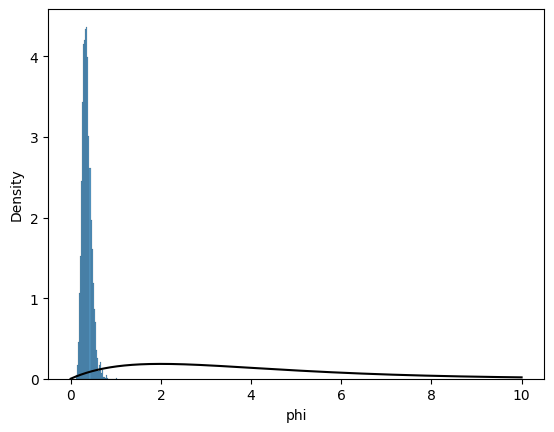

In [3]:
# Prior
x = np.linspace(0, 10, 1000)
sns.lineplot(
    x = x,
    y = gamma.pdf(x, 2.0, scale=2.0),
    color = "black",
)

# Posterior
sns.histplot(
    data=per_draw_df,
    x="phi",
    stat="density",
    bins=40,
)

<Axes: xlabel='b_std', ylabel='Density'>

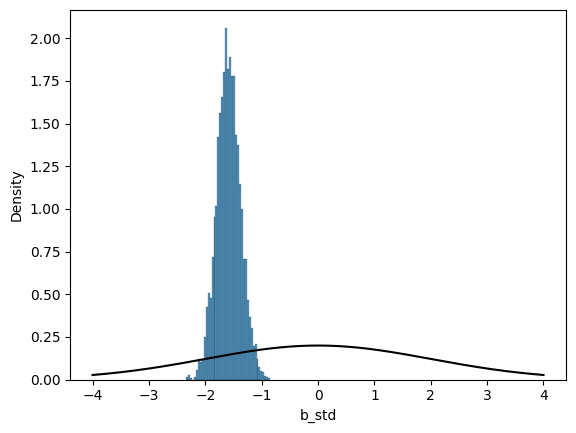

In [4]:
# Prior
#x = np.linspace(0, np.max(per_draw_df["ra_per_predictor"]), 1000)
x = np.linspace(-4, 4, 1000)
sns.lineplot(
    x = x,
    y = norm.pdf(x, scale=2),
    color = "black",
)

# Posterior
sns.histplot(
    data=per_draw_df,
    x="b_std",
    stat="density",
)

## Viral reads over time

In [5]:
def posterior_grid(data, x, y, **kwargs):
    g = sns.relplot(
        data=data[
            (data["observation_type"] == "posterior") 
            & (data["draws"] < 9)
        ],
        x=x,
        y=y,
        col='draws',
        col_wrap=3,
        height=4,
        **kwargs,
    )
    g.set_titles("Posterior draw {col_name:1.0f}")

    ax = g.facet_axis(0, 0)
    for col in ax.collections:
        col.remove()
    sns.scatterplot(
        data=data[data["observation_type"] == "data"],
        x=x,
        y=y,
        ax=ax,
        legend=False,
        **kwargs,
    )
    ax.set_title("Observed", fontdict={"size": 10})
    return g

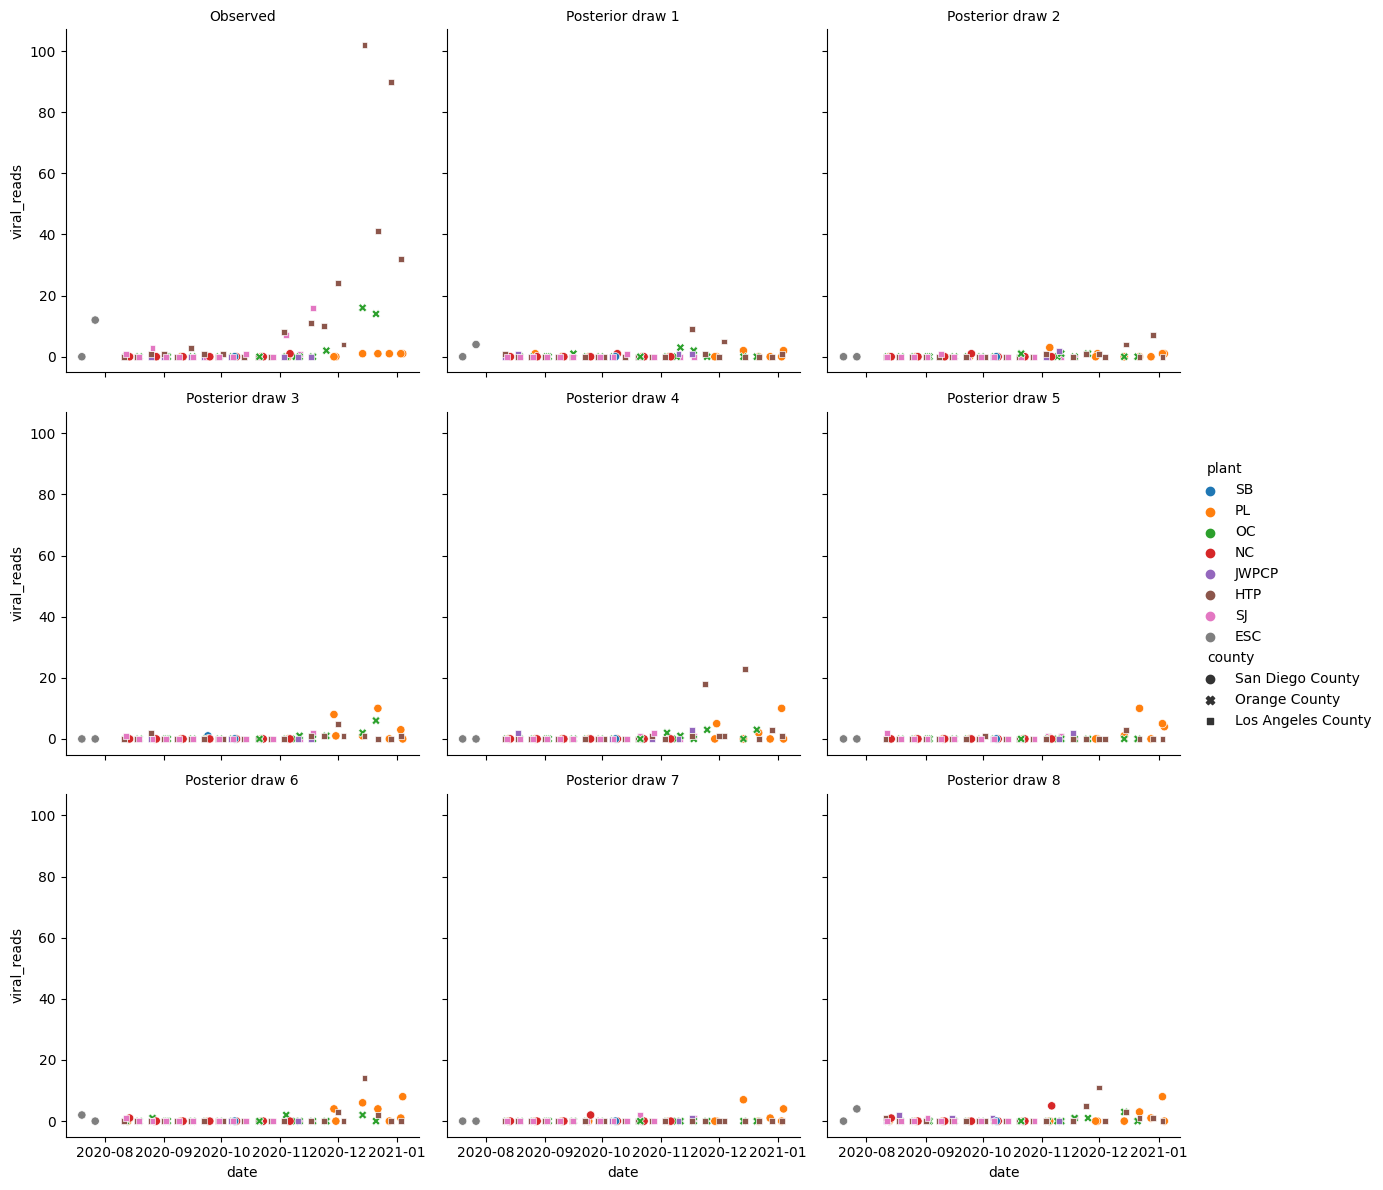

In [6]:
posterior_grid(df, "date", "viral_reads", style="county", hue="plant")

## Incidence vs time

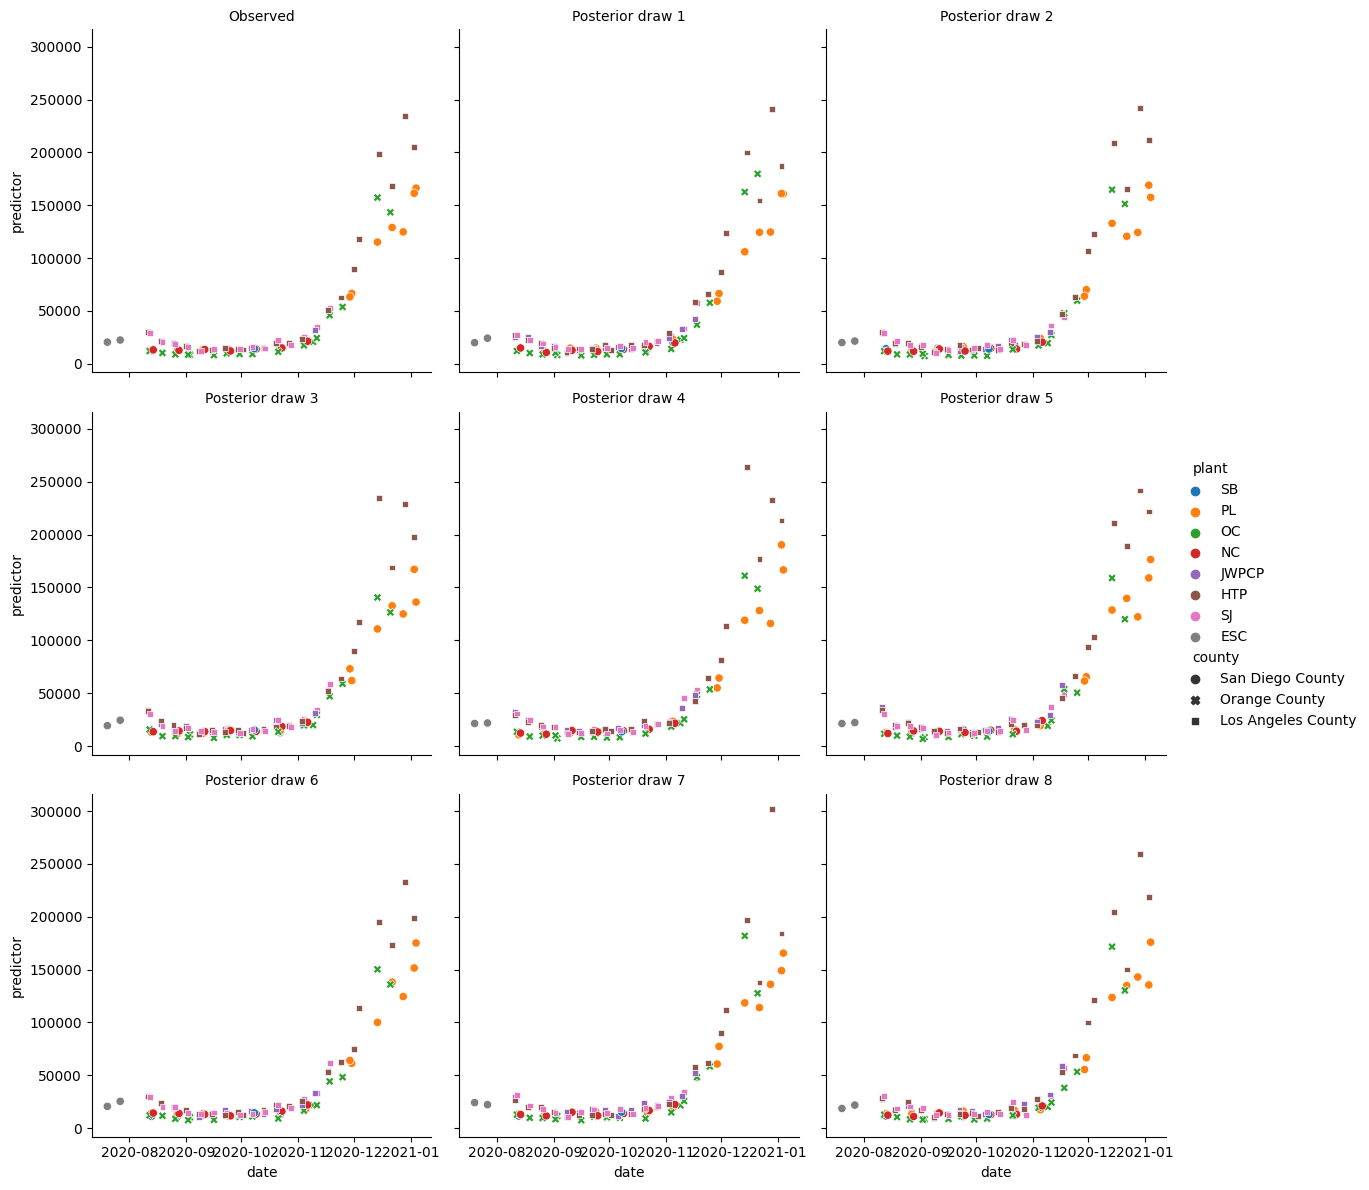

In [7]:
posterior_grid(df, "date", "predictor", style="county", hue="plant")

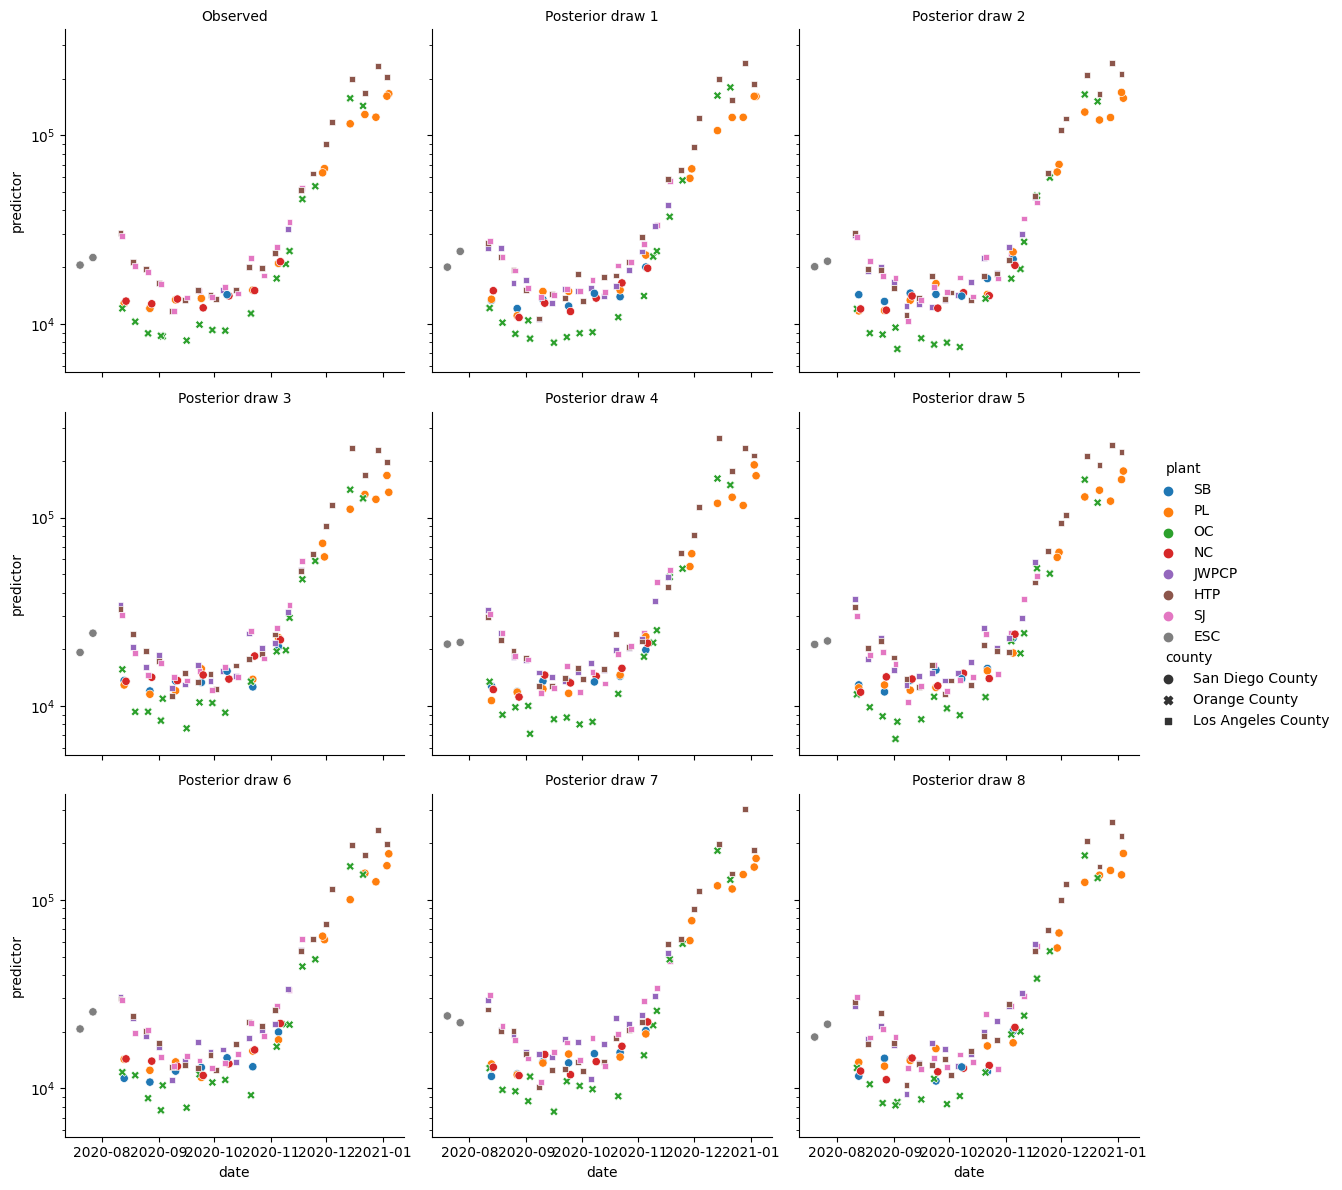

In [8]:
g = posterior_grid(
    df,
    "date",
    "predictor",
    style="county",
    hue="plant",
)
g.set(yscale="log")

## Viral reads vs. incidence

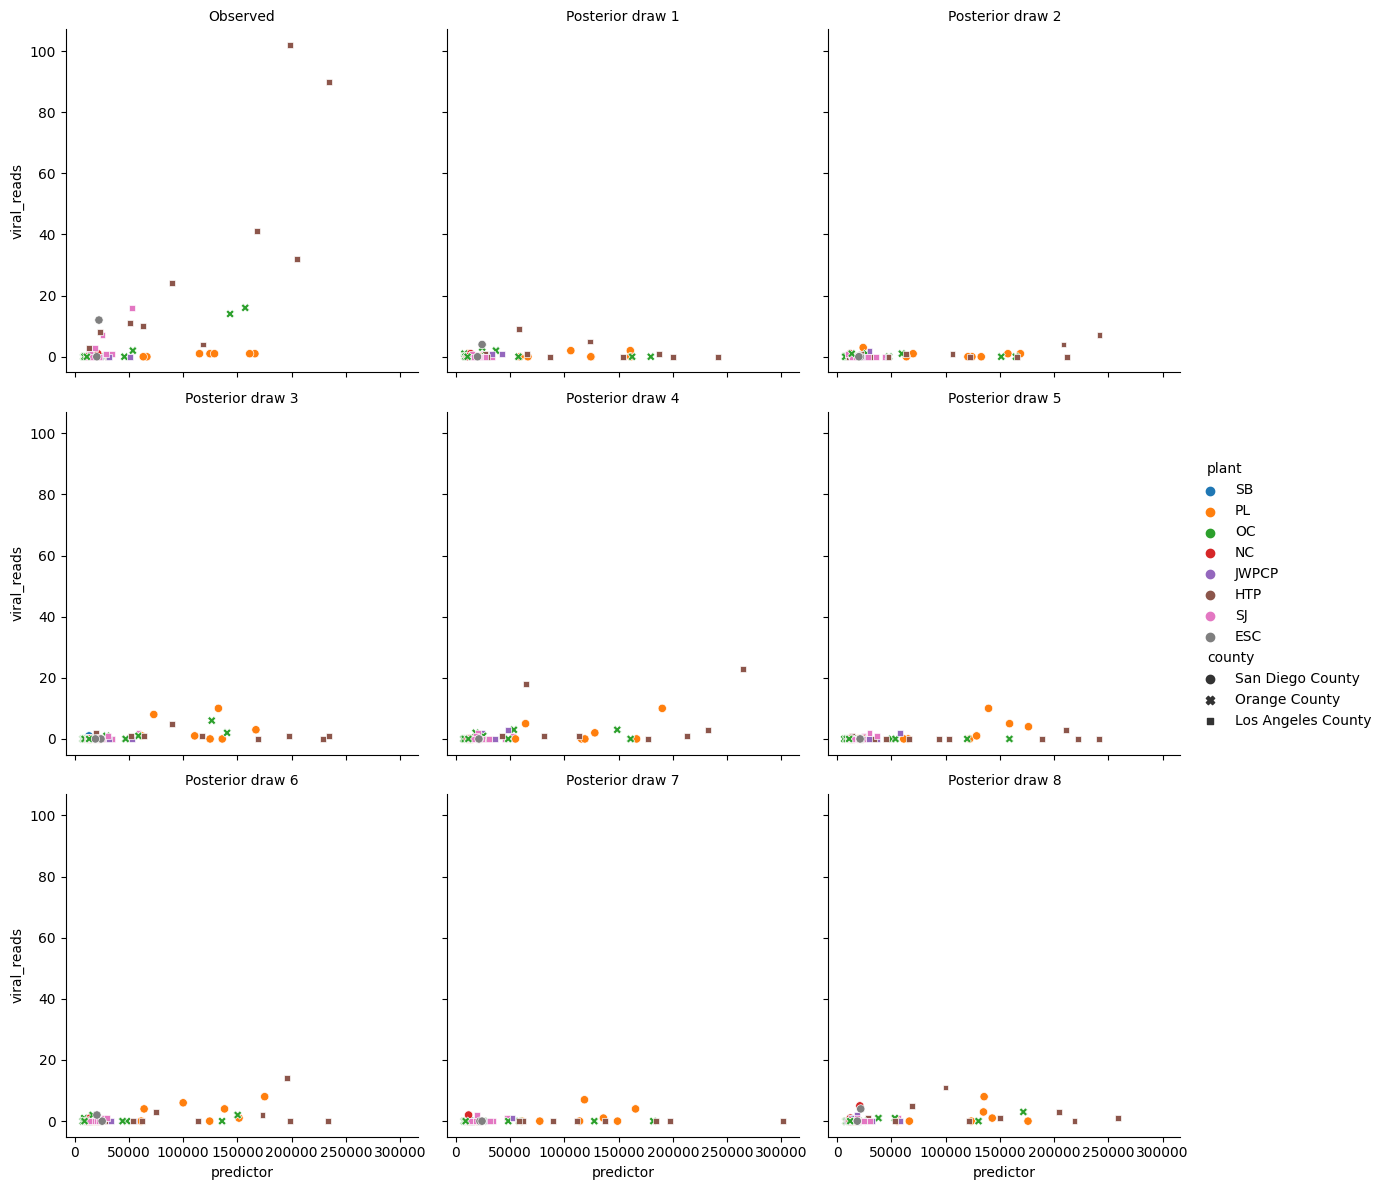

In [9]:
posterior_grid(
    df,
    "predictor",
    "viral_reads",
    style="county",
    hue="plant",
)